In [1]:
!pip install numpy opencv-python matplotlib seaborn tensorflow scikit-learn

In [2]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist,cifar10
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, y_train = x_train[:10000], y_train[:10000]  
x_test, y_test = x_test[:2000], y_test[:2000]        


In [4]:

target_size = (32, 32)
x_train = np.array([cv2.resize(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), target_size) for img in x_train])
x_test = np.array([cv2.resize(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), target_size) for img in x_test])


In [5]:

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


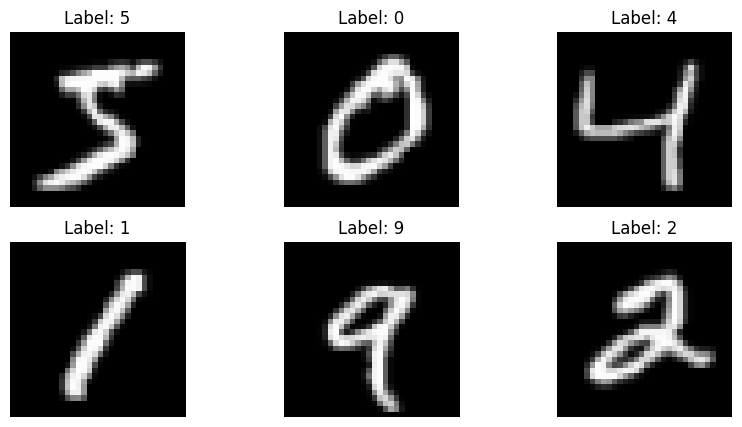

In [6]:

def visualize_samples(images, labels):
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_samples(x_train[:6], y_train[:6])


In [7]:

def create_model(base_model, num_classes=10, learning_rate=0.001):
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [8]:

input_shape = (*target_size, 3)


base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model_resnet.layers:
    layer.trainable = False  # Freeze ResNet50 layers
model_resnet = create_model(base_model_resnet)

base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_model_vgg16.layers:
    layer.trainable = False  # Freeze VGG16 layers
model_vgg16 = create_model(base_model_vgg16)


In [9]:

print("Training ResNet50 model...")
history_resnet = model_resnet.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=32
)


Training ResNet50 model...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 106ms/step - accuracy: 0.5319 - loss: 1.4854 - val_accuracy: 0.7800 - val_loss: 0.7081
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.8056 - loss: 0.6279 - val_accuracy: 0.8055 - val_loss: 0.5751
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8551 - loss: 0.4776 - val_accuracy: 0.8545 - val_loss: 0.4367
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.8722 - loss: 0.4200 - val_accuracy: 0.8755 - val_loss: 0.4020
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 90ms/step - accuracy: 0.8868 - loss: 0.3659 - val_accuracy: 0.8780 - val_loss: 0.3855


In [10]:

print("Training VGG16 model...")
history_vgg16 = model_vgg16.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=5,
    batch_size=32
)


Training VGG16 model...
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6443 - loss: 1.1986 - val_accuracy: 0.8490 - val_loss: 0.4902
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 104ms/step - accuracy: 0.8972 - loss: 0.3588 - val_accuracy: 0.9085 - val_loss: 0.3149
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - accuracy: 0.9258 - loss: 0.2618 - val_accuracy: 0.9240 - val_loss: 0.2615
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.9399 - loss: 0.2025 - val_accuracy: 0.9375 - val_loss: 0.2178
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 121ms/step - accuracy: 0.9457 - loss: 0.1805 - val_accuracy: 0.9335 - val_loss: 0.2172


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.8743 - loss: 0.3732

ResNet50 Test Accuracy: 0.8780, Test Loss: 0.3855
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step


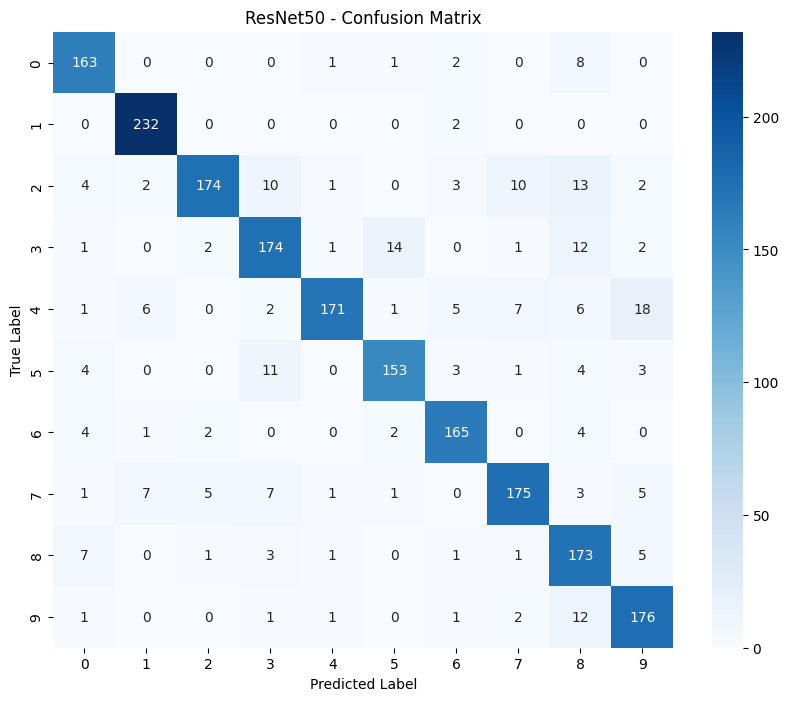

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.9426 - loss: 0.1988

VGG16 Test Accuracy: 0.9335, Test Loss: 0.2172
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step


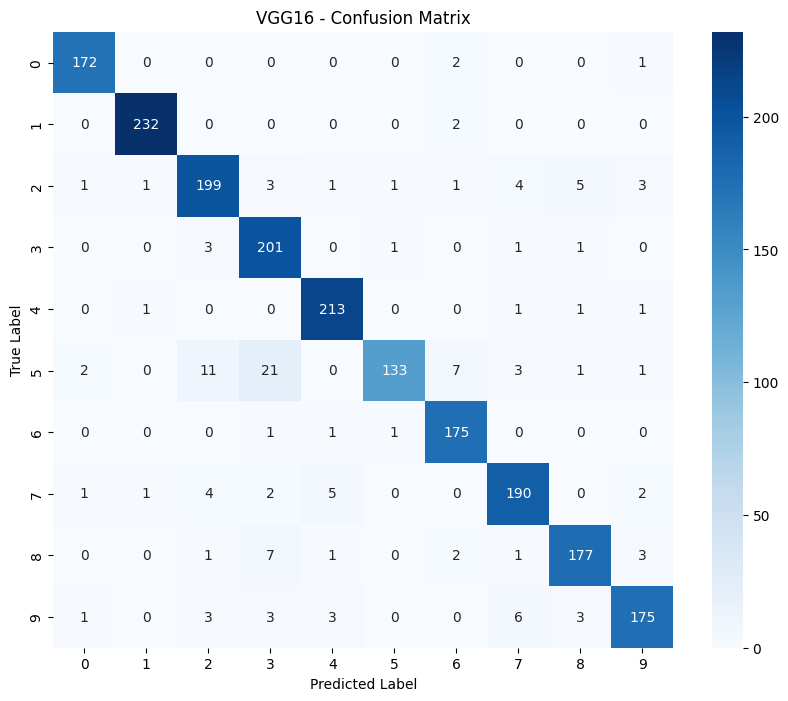

In [11]:

def evaluate_model(model, x_test, y_test, name="Model"):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"\n{name} Test Accuracy: {accuracy:.4f}, Test Loss: {loss:.4f}")
    

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

evaluate_model(model_resnet, x_test, y_test, "ResNet50")

evaluate_model(model_vgg16, x_test, y_test, "VGG16")


In [12]:
model_resnet = create_model(base_model_resnet)
model_vgg16 = create_model(base_model_vgg16)

In [13]:
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    start_time = time.time()
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5, batch_size=32, verbose=1)
    training_time = time.time() - start_time

    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)

    y_pred = np.argmax(model.predict(x_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        'model_name': model_name,
        'test_accuracy': accuracy,
        'training_time': training_time,
        'classification_report': report
    }

results = []
results.append(train_and_evaluate_model(model_resnet, x_train, y_train, x_test, y_test, "ResNet50"))
results.append(train_and_evaluate_model(model_vgg16, x_train, y_train, x_test, y_test, "VGG16"))

for result in results:
    print(f"\n{result['model_name']}:")
    print(f"Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"Training Time: {result['training_time']:.2f} seconds")
    print("\nClassification Report:")
    report = result['classification_report']
    print(f"Macro Avg F1-Score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted Avg F1-Score: {report['weighted avg']['f1-score']:.4f}")

Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 105ms/step - accuracy: 0.5140 - loss: 1.5300 - val_accuracy: 0.7585 - val_loss: 0.7366
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.8093 - loss: 0.6245 - val_accuracy: 0.8040 - val_loss: 0.5873
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 95ms/step - accuracy: 0.8591 - loss: 0.4677 - val_accuracy: 0.8595 - val_loss: 0.4357
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 91ms/step - accuracy: 0.8784 - loss: 0.3903 - val_accuracy: 0.8675 - val_loss: 0.3990
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step - accuracy: 0.8838 - loss: 0.3709 - val_accuracy: 0.8765 - val_loss: 0.3934
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - accuracy: 0.6600 - loss: 1.1732 - val_accuracy: 0.8575 - val_loss: 0.4612
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 33s 106ms/step - accuracy: 0.8928 - loss: 0.3626 - val_accuracy: 0.9110 - val_loss: 0.3009
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step 